In [1]:
import sys
#!{sys.executable} -m pip install lpips pytorch-msssim


import torch                                 #The main library for deep learning
import torch.nn as nn                        #Neural Network module in PyTorch
from torch.nn import AdaptiveAvgPool2d
import torch.nn.functional as F
import torch.optim as optim                  #contains optimizers for training neural networks(SGD,Adam)
from torchvision import datasets             #torchvision is PyTorch library for vision tasks tandard datasets (MNIST, CIFAR10, ImageNet...) ,
from torchvision import datasets, transforms #Preprocessing (resize, normalize, convert to tensor, etc.)
from torchvision.models import inception_v3
from torch.utils.data import DataLoader      #Loads dataset in batches and allows shuffling
from torch.utils.data import Subset          #selects a subset of the dataset, useful for debugging or small experiments.
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt

from pytorch_msssim import ms_ssim
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import lpips
import scipy.linalg
import logging
logging.basicConfig(level=logging.INFO)


In [2]:
# --------------------
# Config
# --------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
image_number = 100      # Use more images for better training
batch_size = 8
epochs = 1
lr = 0.0002
img_size = 256
lambda_G = 1            # Weight for adversarial loss
lambda_L1 = 100         # Weight for L1 reconstruction loss
GlobalFlag = False
save_interval = 10      # Save checkpoint every N epochs

# Training stability settings
use_label_smoothing = True      # Smooth labels to prevent discriminator dominance
real_label_value = 0.9          # Instead of 1.0
fake_label_value = 0.1          # Instead of 0.0

Using device: cpu


In [3]:
# --------------------
# Dataset (MNIST [28x28] → 256x256x1) - Single channel for MRI-to-PET simulation
# --------------------
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),      # [256, 256]
    transforms.ToTensor(),                         # [1, 256, 256], values 0–1
    transforms.Normalize((0.5,), (0.5,))          # [1, 256, 256], values -1 to 1
])

In [4]:

# ----------------
# Load full MNIST datasets
# ----------------
train_data = datasets.MNIST("./data", train=True, download=True, transform=transform)  # Each item is a tuple (image, label)
val_data   = datasets.MNIST("./data", train=False, download=True, transform=transform)

# ----------------
# Create small subset (first 10 images) for both train and val
# ----------------
small_train_data = Subset(train_data, range(image_number))
small_val_data   = Subset(val_data, range(image_number))

# ----------------
# DataLoaders
# ----------------

train_loader = DataLoader(small_train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(small_val_data, batch_size=batch_size, shuffle=False)

Image shape: torch.Size([1, 256, 256])


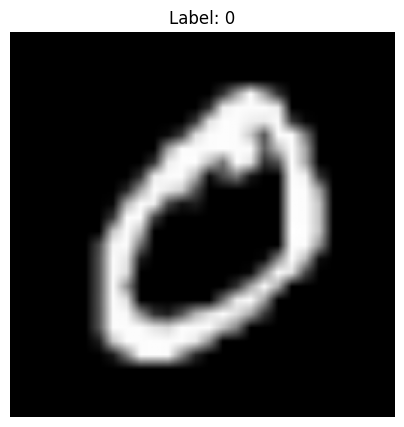

In [5]:
def ShowSample():
    """Display a sample image from the dataset"""
    img, label = train_data[1]  # [1, 256, 256]
    print("Image shape:", img.shape)

    # Convert to [H, W] for grayscale plotting
    img_np = img.squeeze().numpy()  # Remove channel dimension
    img_np = (img_np + 1) / 2  # Denormalize [-1,1] → [0,1]

    plt.figure(figsize=(5, 5))
    plt.imshow(img_np, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

ShowSample()

In [6]:

# --------------------
# Dense Block
# --------------------
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate=32, n_layers=4, dropout=False):
        super().__init__()
        self.layers = nn.ModuleList()
        self.dropout = dropout
        self.flag = GlobalFlag
        for i in range(n_layers):
            self.layers.append(nn.Conv2d(
                in_channels + i * growth_rate, growth_rate, kernel_size=3, padding=1))
            self.layers.append(nn.InstanceNorm2d(growth_rate))
            self.layers.append(nn.LeakyReLU(0.2, inplace=True))
            if dropout:
                self.layers.append(nn.Dropout(0.5))

    def forward(self, x):
        features = [x]
        if self.flag:
            logging.info(f"DenseBlock input: {x.shape}")
        for i in range(0, len(self.layers), 4 if self.dropout else 3):
            out = self.layers[i](torch.cat(features, dim=1))
            out = self.layers[i+1](out)
            out = self.layers[i+2](out)
            if self.dropout:
                out = self.layers[i+3](out)
            features.append(out)
        return torch.cat(features, dim=1)


In [7]:
# --------------------
# Encoder Blocks
# --------------------
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, growth_rate=32, dropout=False):
        super().__init__()
        self.flag = GlobalFlag
        self.dense = DenseBlock(in_channels, growth_rate, n_layers=3, dropout=dropout)
        # Reduce channels to out_channels after dense concatenation
        self.conv1x1 = nn.Conv2d(in_channels + 3*growth_rate, out_channels, kernel_size=1)
        self.downsample = nn.Conv2d(out_channels, out_channels, 4, 2, 1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = self.dense(x)
        x = self.conv1x1(x)
        x = self.downsample(x)
        if self.flag:
            logging.info(f"EncoderBlock input: {x.shape}")
        return self.relu(x)

In [8]:
# --------------------
# Decoder Blocks
# --------------------
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, growth_rate=32, dropout=False):
        super().__init__()
        self.flag = GlobalFlag
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1)
        self.dense = DenseBlock(out_channels, growth_rate, n_layers=3, dropout=dropout)
        self.conv1x1 = nn.Conv2d(out_channels + 3*growth_rate, out_channels, kernel_size=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = self.up(x)
        x = self.dense(x)
        x = self.conv1x1(x)
        if self.flag:
            logging.info(f"DecoderBlock input: {x.shape}")
        return self.relu(x)


In [9]:
# --------------------
# Dense-UNet Generator (U-Net with DenseBlocks)
# --------------------
class Generator(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        """
        Generator for MRI-to-PET synthesis
        Args:
            in_channels: 1 for grayscale MRI
            out_channels: 1 for grayscale PET
        """
        super().__init__()
        self.flag = GlobalFlag

        # Encoder
        self.e1 = EncoderBlock(in_channels, 64)
        self.e2 = EncoderBlock(64, 128)
        self.e3 = EncoderBlock(128, 256)
        self.e4 = EncoderBlock(256, 512)
        self.e5 = EncoderBlock(512, 512)
        self.e6 = EncoderBlock(512, 512)
        self.e7 = EncoderBlock(512, 512, dropout=True)

        # Decoder with skip connections
        self.d1 = DecoderBlock(512, 512, dropout=True)
        self.d2 = DecoderBlock(512+512, 512, dropout=True)
        self.d3 = DecoderBlock(512+512, 512, dropout=True)
        self.d4 = DecoderBlock(512+512, 256)
        self.d5 = DecoderBlock(256+256, 128)
        self.d6 = DecoderBlock(128+128, 64)

        # Final output layer
        self.final = nn.ConvTranspose2d(64+64, out_channels, 4, 2, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Encoder path
        e1 = self.e1(x)
        e2 = self.e2(e1)
        e3 = self.e3(e2)
        e4 = self.e4(e3)
        e5 = self.e5(e4)
        e6 = self.e6(e5)
        e7 = self.e7(e6)

        # Decoder path with skip connections
        d1 = self.d1(e7)
        d2 = self.d2(torch.cat([d1, e6], 1))
        d3 = self.d3(torch.cat([d2, e5], 1))
        d4 = self.d4(torch.cat([d3, e4], 1))
        d5 = self.d5(torch.cat([d4, e3], 1))
        d6 = self.d6(torch.cat([d5, e2], 1))
        out = self.final(torch.cat([d6, e1], 1))

        if self.flag:
            logging.info(f"Generator output: {out.shape}")

        return self.tanh(out)

In [10]:
# --------------------
# PatchGAN Discriminator (Conditional)
# --------------------
class Discriminator(nn.Module):
    def __init__(self, in_channels=2, global_flag=False):
        """
        PatchGAN Discriminator for conditional GAN
        Args:
            in_channels: 2 (input_image + output_image concatenated)
        """
        super().__init__()
        self.flag = global_flag

        # PatchGAN: C64-C128-C256-C512
        # Note: Using InstanceNorm2d instead of BatchNorm2d for better image translation
        self.model = nn.Sequential(
            # C64: No normalization on first layer
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # C128
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # C256
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # C512
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # C512 (additional layer)
            nn.Conv2d(512, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Output: 1-channel patch predictions
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        if self.flag:
            logging.info(f"Discriminator input: {x.shape}")
        return self.model(x)

In [11]:
# --------------------
# Init Models, Loss & Optimizers
# --------------------
import os
os.makedirs('checkpoints', exist_ok=True)

# Initialize models
G = Generator(in_channels=1, out_channels=1).to(device)
D = Discriminator(in_channels=2).to(device)  # 2 channels: input + output

# Loss functions
adversarial_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

# Optimizers with slightly different learning rates
opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=lr * 0.5, betas=(0.5, 0.999))  # D learns slower

# IMPROVED: Gentler learning rate schedulers
scheduler_G = optim.lr_scheduler.StepLR(opt_G, step_size=100, gamma=0.5)  # Changed from 50
scheduler_D = optim.lr_scheduler.StepLR(opt_D, step_size=100, gamma=0.5)  # Changed from 50

print(f"Generator parameters: {sum(p.numel() for p in G.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in D.parameters()):,}")

Generator parameters: 50,691,969
Discriminator parameters: 6,958,529


In [12]:
def plot_ssim_changes(ssim_values, title="SSIM changes"):
    """
    ssim_values: list or numpy array of SSIM values
    """
    ssim_values = np.array(ssim_values)

    plt.figure(figsize=(8,4))
    plt.plot(ssim_values, marker='o')
    plt.xlabel("Image index")
    plt.ylabel("SSIM")
    plt.ylim(0, 1)
    plt.title(title)
    plt.grid(True)
    plt.show()

Starting training...
Epoch [  1/1] | Time: 1.3min | G: 28.2597 | D: 0.7005 | SSIM: 0.7730 | Best SSIM: 0.7730

✅ Training completed in 1.3 minutes
Best SSIM: 0.7730


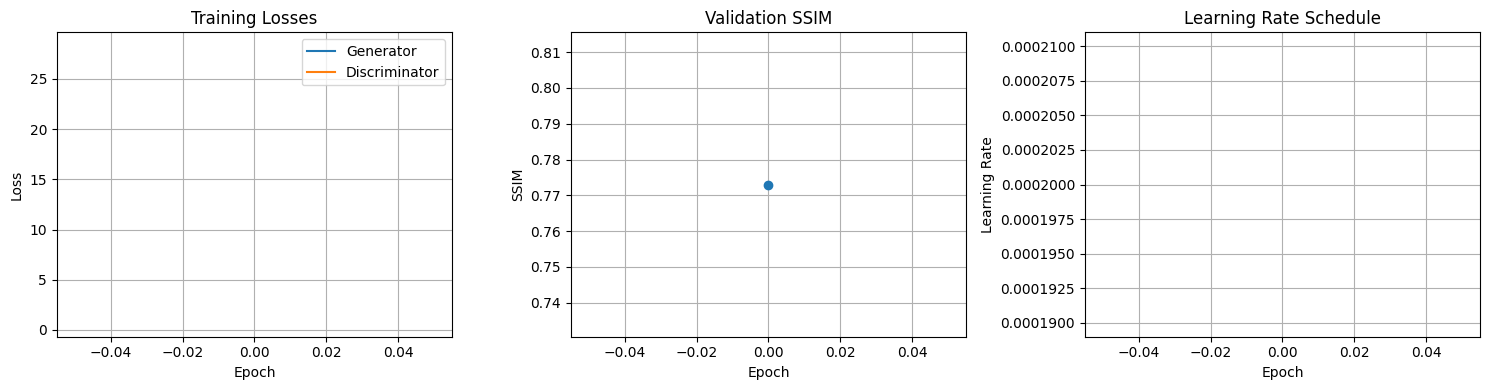

In [13]:
# --------------------
# TRAINING LOOP (Conditional GAN) ✅
# --------------------
import time

ssim_values = []
g_losses = []
d_losses = []
best_ssim = 0.0

print("Starting training...")
start_time = time.time()

for epoch in range(epochs):
    G.train()
    D.train()

    epoch_g_loss = 0.0
    epoch_d_loss = 0.0

    for batch_idx, (imgs, _) in enumerate(train_loader):
        imgs = imgs.to(device)
        batch_size_current = imgs.size(0)

        # ======================
        #  Train Generator
        # ======================
        opt_G.zero_grad()

        # Generate fake images
        gen_imgs = G(imgs)

        # CRITICAL: Discriminator sees [input, output] concatenated
        fake_pair = torch.cat([imgs, gen_imgs], dim=1)  # [B, 2, H, W]
        pred_fake = D(fake_pair)

        # Generator wants discriminator to think fake is real
        # Use label smoothing if enabled
        if use_label_smoothing:
            valid = torch.ones_like(pred_fake) * real_label_value
        else:
            valid = torch.ones_like(pred_fake)

        g_adv_loss = adversarial_loss(pred_fake, valid)

        # L1 reconstruction loss
        g_l1_loss = l1_loss(gen_imgs, imgs)

        # Total generator loss
        loss_G = lambda_G * g_adv_loss + lambda_L1 * g_l1_loss

        loss_G.backward()
        torch.nn.utils.clip_grad_norm_(G.parameters(), max_norm=5.0)  # Gradient clipping
        opt_G.step()

        epoch_g_loss += loss_G.item()

        # ======================
        #  Train Discriminator
        # ======================
        opt_D.zero_grad()

        # Real pairs: [input, input] (for autoencoder) or [input, target]
        real_pair = torch.cat([imgs, imgs], dim=1)  # [B, 2, H, W]
        pred_real = D(real_pair)

        # Use label smoothing if enabled
        if use_label_smoothing:
            real_labels = torch.ones_like(pred_real) * real_label_value
        else:
            real_labels = torch.ones_like(pred_real)

        real_loss = adversarial_loss(pred_real, real_labels)

        # Fake pairs: [input, generated]
        fake_pair = torch.cat([imgs, gen_imgs.detach()], dim=1)
        pred_fake = D(fake_pair)

        if use_label_smoothing:
            fake_labels = torch.ones_like(pred_fake) * fake_label_value
        else:
            fake_labels = torch.zeros_like(pred_fake)

        fake_loss = adversarial_loss(pred_fake, fake_labels)

        # Total discriminator loss
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        torch.nn.utils.clip_grad_norm_(D.parameters(), max_norm=5.0)  # Gradient clipping
        opt_D.step()

        epoch_d_loss += d_loss.item()

    # Update learning rates
    scheduler_G.step()
    scheduler_D.step()

    # Average losses
    avg_g_loss = epoch_g_loss / len(train_loader)
    avg_d_loss = epoch_d_loss / len(train_loader)
    g_losses.append(avg_g_loss)
    d_losses.append(avg_d_loss)

    # ======================
    #  Validation
    # ======================
    G.eval()
    mse_val, ssim_epoch, n = 0.0, 0.0, 0

    with torch.no_grad():
        for imgs, _ in val_loader:
            imgs = imgs.to(device)
            gen = G(imgs)

            # Convert to numpy for metrics: [-1,1] → [0,1]
            gen_np = ((gen.cpu().numpy() + 1) / 2).clip(0, 1)
            real_np = ((imgs.cpu().numpy() + 1) / 2).clip(0, 1)

            for i in range(gen_np.shape[0]):
                # For grayscale: [1, H, W] → [H, W]
                gen_img = gen_np[i, 0]
                real_img = real_np[i, 0]

                ssim_epoch += ssim(real_img, gen_img, data_range=1.0)
                n += 1

    ssim_epoch /= n
    ssim_values.append(ssim_epoch)

    # ======================
    #  Check for collapse
    # ======================
    if epoch > 10 and avg_d_loss < 0.01:
        print(f"⚠️  Warning: Discriminator too strong (D loss: {avg_d_loss:.4f})")

    # ======================
    #  Save best model
    # ======================
    if ssim_epoch > best_ssim:
        best_ssim = ssim_epoch
        torch.save({
            'epoch': epoch,
            'G_state_dict': G.state_dict(),
            'D_state_dict': D.state_dict(),
            'opt_G_state_dict': opt_G.state_dict(),
            'opt_D_state_dict': opt_D.state_dict(),
            'best_ssim': best_ssim,
        }, 'checkpoints/best_model.pth')

    # ======================
    #  Save checkpoint periodically
    # ======================
    if (epoch + 1) % save_interval == 0:
        torch.save({
            'epoch': epoch,
            'G_state_dict': G.state_dict(),
            'D_state_dict': D.state_dict(),
            'opt_G_state_dict': opt_G.state_dict(),
            'opt_D_state_dict': opt_D.state_dict(),
            'ssim_values': ssim_values,
            'g_losses': g_losses,
            'd_losses': d_losses,
        }, f'checkpoints/checkpoint_epoch_{epoch+1}.pth')

    # ======================
    #  Print progress
    # ======================
    elapsed = time.time() - start_time
    print(
        f"Epoch [{epoch+1:3d}/{epochs}] | "
        f"Time: {elapsed/60:.1f}min | "
        f"G: {avg_g_loss:.4f} | "
        f"D: {avg_d_loss:.4f} | "
        f"SSIM: {ssim_epoch:.4f} | "
        f"Best SSIM: {best_ssim:.4f}"
    )

print(f"\n✅ Training completed in {elapsed/60:.1f} minutes")
print(f"Best SSIM: {best_ssim:.4f}")

# Plot training metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(g_losses, label='Generator')
axes[0].plot(d_losses, label='Discriminator')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Losses')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(ssim_values, marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('SSIM')
axes[1].set_title('Validation SSIM')
axes[1].grid(True)

axes[2].plot([opt_G.param_groups[0]['lr']] * len(g_losses))
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('checkpoints/training_curves.png', dpi=150)
plt.show()

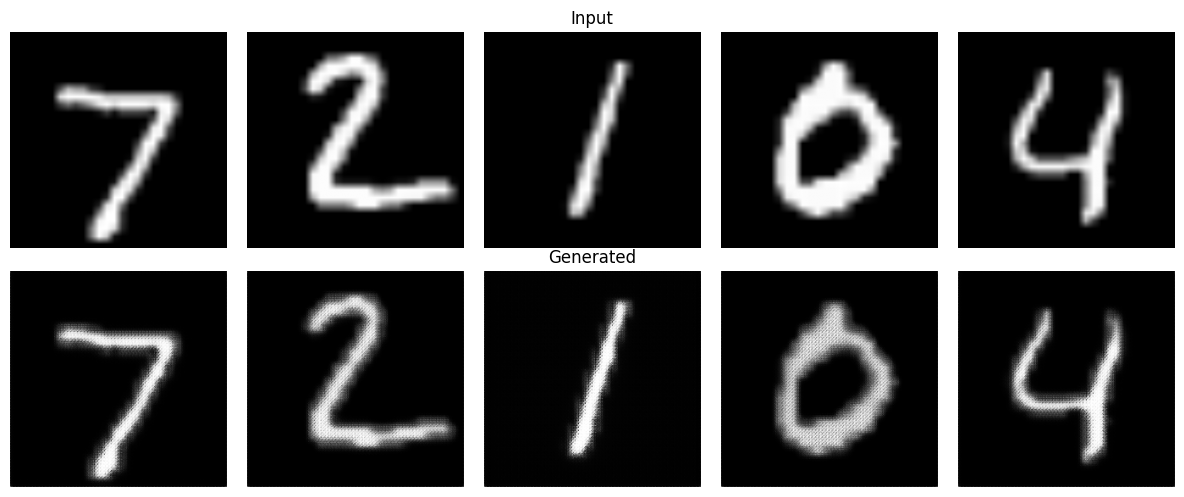

In [14]:
# --------------------
# Generate & Show Images
# --------------------
def show_results(model, loader, num_images=5):
    """Visualize input vs generated images"""
    model.eval()
    imgs, _ = next(iter(loader))
    imgs = imgs[:num_images].to(device)

    with torch.no_grad():
        gen = model(imgs)

    # Denormalize: [-1,1] → [0,1]
    imgs = (imgs.cpu() + 1) / 2
    gen = (gen.cpu() + 1) / 2

    plt.figure(figsize=(12, 5))
    for i in range(num_images):
        # Input images
        plt.subplot(2, num_images, i+1)
        plt.imshow(imgs[i, 0], cmap='gray')
        plt.title('Input' if i == 2 else '')
        plt.axis("off")

        # Generated images
        plt.subplot(2, num_images, i+1+num_images)
        plt.imshow(gen[i, 0], cmap='gray')
        plt.title('Generated' if i == 2 else '')
        plt.axis("off")

    plt.tight_layout()
    plt.savefig('checkpoints/generated_samples.png', dpi=150)
    plt.show()

show_results(G, val_loader)

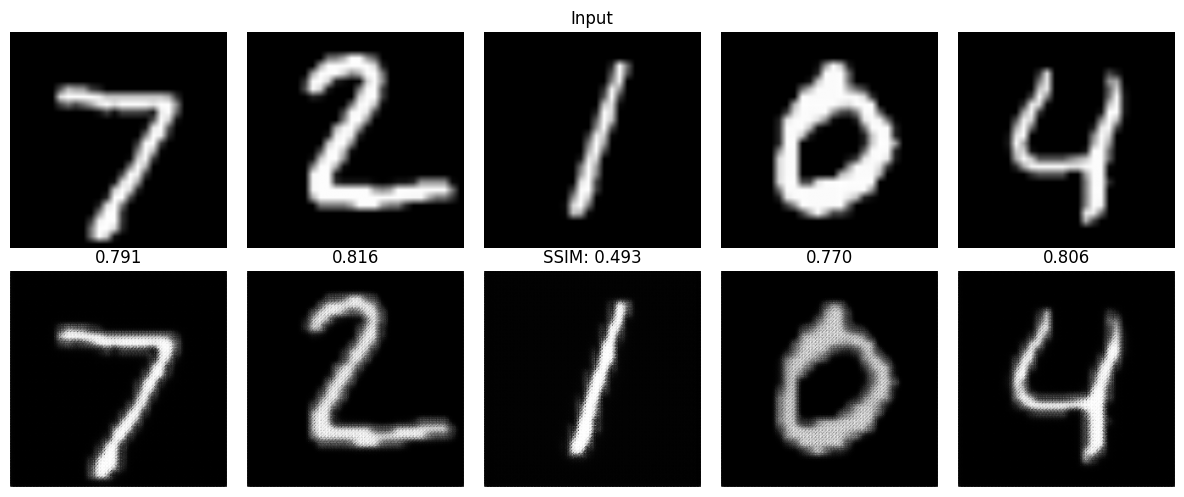

Average SSIM: 0.7352
SSIM scores: ['0.7906', '0.8161', '0.4928', '0.7704', '0.8061']


[np.float64(0.7906031341325045),
 np.float64(0.81613444093512),
 np.float64(0.4928249979754575),
 np.float64(0.7704241357080563),
 np.float64(0.8061173470335826)]

In [15]:
def generate_and_evaluate_ssim(generator, dataloader, device, num_images=5):
    """
    Generate images and evaluate SSIM with visualization
    """
    generator.eval()

    # Get real images
    real_imgs, _ = next(iter(dataloader))
    real_imgs = real_imgs[:num_images].to(device)

    # Generate images
    with torch.no_grad():
        gen_imgs = generator(real_imgs)

    # Convert to numpy and denormalize: [-1,1] → [0,1]
    real_np = ((real_imgs.cpu().numpy() + 1) / 2).clip(0, 1)
    gen_np = ((gen_imgs.cpu().numpy() + 1) / 2).clip(0, 1)

    ssim_scores = []

    # Plot comparison
    plt.figure(figsize=(12, 5))
    for i in range(num_images):
        # Real images
        plt.subplot(2, num_images, i+1)
        plt.imshow(real_np[i, 0], cmap="gray", vmin=0, vmax=1)
        plt.title("Input" if i == 2 else "")
        plt.axis("off")

        # Generated images
        plt.subplot(2, num_images, i+1+num_images)
        plt.imshow(gen_np[i, 0], cmap="gray", vmin=0, vmax=1)

        # Calculate SSIM
        score = ssim(real_np[i, 0], gen_np[i, 0], data_range=1.0)
        ssim_scores.append(score)
        plt.title(f"SSIM: {score:.3f}" if i == 2 else f"{score:.3f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Average SSIM: {np.mean(ssim_scores):.4f}")
    print(f"SSIM scores: {[f'{s:.4f}' for s in ssim_scores]}")

    return ssim_scores

# Evaluate on validation set
generate_and_evaluate_ssim(G, val_loader, device, num_images=5)

In [16]:
# --------------------
# Load Best Model (Optional)
# --------------------
def load_checkpoint(checkpoint_path):
    """Load a saved checkpoint"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    G.load_state_dict(checkpoint['G_state_dict'])
    D.load_state_dict(checkpoint['D_state_dict'])
    print(f"✅ Loaded checkpoint from epoch {checkpoint['epoch']}")
    if 'best_ssim' in checkpoint:
        print(f"   Best SSIM: {checkpoint['best_ssim']:.4f}")
    return checkpoint

# Example: Load best model
# checkpoint = load_checkpoint('checkpoints/best_model.pth')


In [17]:
real_imgs, _ = next(iter(train_loader))
real_imgs = real_imgs[:1].to(device)
gen_imgs = G(real_imgs)

real_imgs = (real_imgs + 1) / 2    #[-1,+1]->[0,1]
gen_imgs = (gen_imgs + 1) / 2

In [18]:
# --------------------
# NMSE: Normalized MSE ↓
# --------------------
def NMSE(x, y):        # x, y: [B, C, H, W], values [0,1]
    mse = F.mse_loss(x, y, reduction='none')
    nmse = mse.view(mse.size(0), -1).sum(dim=1) / (y.view(y.size(0), -1)**2).sum(dim=1)
    return nmse.mean().item()

In [19]:
# --------------------
# NMAE: Normalized MAE ↓
# --------------------
def NMAE(x, y, eps=1e-8):
    num = torch.abs(x - y).view(x.size(0), -1).sum(dim=1)
    den = torch.abs(y).view(y.size(0), -1).sum(dim=1) + eps
    return (num / den).mean().item()

In [20]:
# --------------------
# PSNR ↑
# --------------------
def PSNR(x, y, max_val=1.0):
    x_np = x.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()
    psnr_vals = [psnr(y_np[i], x_np[i], data_range=max_val) for i in range(x_np.shape[0])]
    return np.mean(psnr_vals)

In [21]:
# --------------------
# SSIM ↑
# --------------------
def SSIM(x, y):
    x_np = x.detach().cpu().numpy().astype(np.float32)
    y_np = y.detach().cpu().numpy().astype(np.float32)

    ssim_vals = []
    for i in range(x_np.shape[0]):
        # Convert from [C,H,W] to [H,W,C]
        ssim_val = ssim(
            y_np[i].transpose(1,2,0),
            x_np[i].transpose(1,2,0),
            channel_axis=2,
            data_range=1.0
        )
        ssim_vals.append(ssim_val)

    return np.mean(ssim_vals)

In [22]:
# --------------------
# MS-SSIM ↓ (1 - ms-ssim)
# --------------------
def MS_SSIM(x, y):
    return 1 - ms_ssim(x, y, data_range=1.0, size_average=True).item()

In [23]:
# --------------------
# LPIPS ↓
# --------------------

lpips_alex = lpips.LPIPS(net='alex').to(device)
def LPIPS(x, y):
    return lpips_alex(x*2-1, y*2-1).mean().item()  # scale to [-1,1]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\fhabi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\fhabi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\fhabi\AppData\Local\Programs\Python\Python310\lib\site-packages\lpips\weights\v0.1\alex.pth


In [24]:
# --------------------
# FID ↓
# --------------------
def FID(x, y, device=None, eps=1e-6):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')

    if x.shape[0] < 2 or y.shape[0] < 2:
        raise ValueError("FID requires at least 2 images")

    weights = Inception_V3_Weights.DEFAULT
    inception = inception_v3(weights=weights, aux_logits=False)
    inception.fc = torch.nn.Identity()
    inception.to(device).eval()

    def preprocess(imgs):
        if imgs.shape[1] == 1:
            imgs = imgs.repeat(1, 3, 1, 1)
        elif imgs.shape[1] == 2:
            imgs = torch.cat([imgs, imgs[:, :1]], dim=1)
        elif imgs.shape[1] != 3:
            raise ValueError("Channels must be 1, 2, or 3")
        return F.interpolate(imgs, size=(299, 299), mode='bilinear', align_corners=False)

    def get_features(imgs):
        imgs = preprocess(imgs.to(device))
        with torch.no_grad():
            feats = inception(imgs)
        feats = feats.cpu().numpy().astype(np.float64)

        if not np.isfinite(feats).all():
            raise ValueError("NaN or Inf detected in Inception features")

        return feats

    fx = get_features(x)
    fy = get_features(y)

    mu_x, mu_y = fx.mean(0), fy.mean(0)
    sigma_x = np.cov(fx, rowvar=False)
    sigma_y = np.cov(fy, rowvar=False)

    # Regularize covariance (CRITICAL)
    sigma_x += np.eye(sigma_x.shape[0]) * eps
    sigma_y += np.eye(sigma_y.shape[0]) * eps

    covmean, _ = linalg.sqrtm(sigma_x @ sigma_y, disp=False)

    if not np.isfinite(covmean).all():
        covmean = linalg.sqrtm(
            (sigma_x + sigma_y) / 2
        )

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = np.sum((mu_x - mu_y) ** 2) + np.trace(sigma_x + sigma_y - 2 * covmean)
    return float(fid)

In [ ]:
print('NMSE(↓):',NMSE(gen_imgs,real_imgs))
print('NMAE(↓):',NMAE(gen_imgs,real_imgs))
print('PSNR(↑):',PSNR(gen_imgs,real_imgs))
print('SSIM(↑):',SSIM(gen_imgs,real_imgs))
print('MS_SSIM(↑):',MS_SSIM(gen_imgs,real_imgs))
#print('FID(↓):',FID(torch.cat(gen_imgs, dim=0),torch.cat(real_imgs, dim=0)))
#print('LPIPS(↓):',LPIPS(gen_imgs,real_imgs))
##

NMSE(↓): 0.1536068618297577
NMAE(↓): 0.407566100358963
PSNR(↑): 15.949494310994448
SSIM(↑): 0.73750746
MS_SSIM(↑): 0.12996423244476318
